In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train=pd.read_csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")

In [ ]:
train

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
train['activity_enc']=le.fit_transform(train['activity'])
train['up_enc']=le2.fit_transform(train['up_event'])
train['down_enc']=le3.fit_transform(train['down_event'])

In [ ]:
train.head()

In [ ]:
train['activity'].unique()

*Here we can see up event is different by one action, lets check *

In [ ]:
diff_key_down=set(train['down_event'].unique())-set(train['up_event'].unique())
diff_key_up=set(train['up_event'].unique())-set(train['down_event'].unique())

print(f'Key present in down event but not in up {diff_key_down} and key present in up even only {diff_key_up}')

In [ ]:
train.groupby('id')['action_time'].sum()

In [ ]:
train_score=pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')

In [ ]:
train_score.tail()

In [ ]:
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(10,5))
stat=train.groupby('id')['action_time'].sum().div(1000).to_frame()
stats_score = stat.merge(train_score, on='id')
plt.bar(stats_score['score'],stats_score['action_time'],)

plt.ylabel('action time')
plt.xlabel('score')

plt.show()


In [ ]:
#here I will groupy the id and make new features so we can apply meaningful models here
model_train=pd.DataFrame({'id':train['id'].unique()})

# Feature from events
model_train['count_of_events']=train['event_id'].groupby([train['id']]).max().values
# Let's get feature from time
model_train['mean_down_time']=train['down_time'].groupby([train['id']]).mean().values
model_train['mean_up_time']=train['up_time'].groupby([train['id']]).mean().values
model_train['mean_action_time']=train['action_time'].groupby([train['id']]).mean().values
model_train['median_down_time']=train['down_time'].groupby([train['id']]).median().values
model_train['median_up_time']=train['up_time'].groupby([train['id']]).median().values
model_train['median_action_time']=train['action_time'].groupby([train['id']]).median().values

# word count
model_train['count_word_count']=train['word_count'].groupby([train['id']]).max().values
model_train['mean_word_count']=train['word_count'].groupby([train['id']]).mean().values
model_train['median_word_count']=train['word_count'].groupby([train['id']]).median().values

# mode shows that number of time/events user spent the most - can say blockage word?
model_train['idle_word_count']=train['word_count'].groupby([train['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1]).values

# cursor positon
model_train['count_cursor_position']=train['cursor_position'].groupby([train['id']]).max().values
model_train['mean_cursor_position']=train['cursor_position'].groupby([train['id']]).mean().values

# median shows the idle time ?
model_train['median_cursor_position']=train['cursor_position'].groupby([train['id']]).median().values
# The mode can tell the idle time of cursor
model_train['idle_cursor_position']=train['cursor_position'].groupby([train['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1] ).values

# Let's do the features now, we will basically do one encode or count the features basically

model_train['common_activity']=train['activity_enc'].groupby([train['id']]).agg(pd.Series.mode).values
model_train['common_up_event']=train['up_enc'].groupby([train['id']]).agg(pd.Series.mode).values
model_train['common_down_event']=train['down_enc'].groupby([train['id']]).apply(lambda x: x.value_counts().idxmax()).values

# activity mapping 
model_train['count_input']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Input').sum()).values
model_train['count_remove']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Remove/Cut').sum()).values
model_train['count_nonproduction']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Nonproduction').sum()).values
model_train['count_replace']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Replace').sum()).values
model_train['count_paste']=train['activity'].groupby([train['id']]).apply(lambda x: (x == 'Paste').sum()).values
model_train['input_back_ratio']=model_train['count_input']/model_train['count_remove']


for ele in train['down_event'].value_counts().index[:10]:
    model_train['count_down_'+ele]=train['down_event'].groupby([train['id']]).apply(lambda x: (x == ele).sum()).values

for ele in train['up_event'].value_counts().index[:10]:
    model_train['count_up_'+ele]=train['up_event'].groupby([train['id']]).apply(lambda x: (x == ele).sum()).values
    
    
    

model_train

In [ ]:
model_train.to_csv('/kaggle/working/model_train_final_withencoding2.csv',index=False)

In [ ]:
import numpy
numpy.save('classes.npy', le.classes_)
numpy.save('classesup.npy', le2.classes_)
numpy.save('classesdown.npy', le3.classes_)

In [ ]:
model_train=pd.read_csv('/kaggle/input/linking-cleaned/model_train_final_withencoding2.csv')
model_train

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()

In [ ]:
import numpy
le.classes_ = numpy.load('/kaggle/input/linking-cleaned/classes.npy',allow_pickle=True)
le2.classes_ = numpy.load('/kaggle/input/linking-cleaned/classesup.npy',allow_pickle=True)
le3.classes_ = numpy.load('/kaggle/input/linking-cleaned/classesdown.npy',allow_pickle=True)



In [ ]:
test=pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')
test

In [ ]:
test['activity_enc']=le.fit_transform(test['activity'])
test['up_enc']=le2.fit_transform(test['up_event'])
test['down_enc']=le3.fit_transform(test['down_event'])

In [ ]:
#here I will groupy the id and make new features so we can apply meaningful models here
model_test=pd.DataFrame({'id':test['id'].unique()})

# Feature from events
model_test['count_of_events']=test['event_id'].groupby([test['id']]).max().values
# Let's get feature from time
model_test['mean_down_time']=test['down_time'].groupby([test['id']]).mean().values
model_test['mean_up_time']=test['up_time'].groupby([test['id']]).mean().values
model_test['mean_action_time']=test['action_time'].groupby([test['id']]).mean().values
model_test['median_down_time']=test['down_time'].groupby([test['id']]).median().values
model_test['median_up_time']=test['up_time'].groupby([test['id']]).median().values
model_test['median_action_time']=test['action_time'].groupby([test['id']]).median().values

# word count
model_test['count_word_count']=test['word_count'].groupby([test['id']]).max().values
model_test['mean_word_count']=test['word_count'].groupby([test['id']]).mean().values
model_test['median_word_count']=test['word_count'].groupby([test['id']]).median().values

# mode shows that number of time/events user spent the most - can say blockage word?
model_test['idle_word_count']=test['word_count'].groupby([test['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1]).values

# cursor positon
model_test['count_cursor_position']=test['cursor_position'].groupby([test['id']]).max().values
model_test['mean_cursor_position']=test['cursor_position'].groupby([test['id']]).mean().values

# median shows the idle time ?
model_test['median_cursor_position']=test['cursor_position'].groupby([test['id']]).median().values
# The mode can tell the idle time of cursor
model_test['idle_cursor_position']=test['cursor_position'].groupby([test['id']]).apply(lambda x: x.value_counts().idxmax() if x.value_counts().max() > 1 else x.iloc[-1] ).values

# Let's do the features now, we will basically do one encode or count the features basically

model_test['common_activity']=test['activity_enc'].groupby([test['id']]).agg(pd.Series.mode).values
model_test['common_up_event']=test['up_enc'].groupby([test['id']]).agg(pd.Series.mode).values
model_test['common_down_event']=test['down_enc'].groupby([test['id']]).apply(lambda x: x.value_counts().idxmax()).values

# activity mapping 
model_test['count_input']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Input').sum()).values
model_test['count_remove']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Remove/Cut').sum()).values
model_test['count_nonproduction']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Nonproduction').sum()).values
model_test['count_replace']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Replace').sum()).values
model_test['count_paste']=test['activity'].groupby([test['id']]).apply(lambda x: (x == 'Paste').sum()).values
model_test['input_back_ratio']=model_test['count_input']/model_test['count_remove']


for ele in test['down_event'].value_counts().index[:10]:
    model_test['count_down_'+ele]=test['down_event'].groupby([test['id']]).apply(lambda x: (x == ele).sum()).values

for ele in test['up_event'].value_counts().index[:10]:
    model_test['count_up_'+ele]=test['up_event'].groupby([test['id']]).apply(lambda x: (x == ele).sum()).values
    
    
    

model_test

In [ ]:
model_test.to_csv('/kaggle/working/model_test.csv',index=False)

In [ ]:
model_train

In [ ]:
type(model_train.id[0])

In [ ]:
for column in model_train.columns:
    if model_train[column].apply(lambda x: isinstance(x, str)).any():
        print(f"Column '{column}' contains string values.")

In [ ]:
model_train_score=pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
'''score_dict={0.0: 0 , 0.5 : 1 , 1.0 : 2 , 1.5:3 , 2.0 : 4 , 2.5:5 , 3.0:6 , 3.5:7,4.0:8,4.5:9,5.0:10,5.5:11,6.0:12}
def score_enc(x):
    return score_dict[x]

model_train_score['score']=model_train_score['score'].apply(score_enc)
from sklearn.model_selection import KFold,LeaveOneOut
loo=LeaveOneOut()
skf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_indices = []
#model_train=model_train.drop(columns=['id'])
model_train_score=model_train_score.drop(columns=['id'])
for train_idx,test_idx in skf.split(model_train):
    fold_indices.append({
        'train_indices': train_idx.tolist(),
        'test_indices': test_idx.tolist()
    })
'''
    

In [ ]:
import json
with open('/kaggle/working/k_fold_indices_10.json', 'w') as file:
    json.dump(fold_indices, file)

In [ ]:
from sklearn.utils.multiclass import type_of_target
type_of_target(model_train_score.score)

In [ ]:
score_dict={0.0: 0 , 0.5 : 1 , 1.0 : 2 , 1.5:3 , 2.0 : 4 , 2.5:5 , 3.0:6 , 3.5:7,4.0:8,4.5:9,5.0:10,5.5:11,6.0:12}
def score_enc(x):
    return score_dict[x]

model_train_score['score']=model_train_score['score'].apply(score_enc)

In [ ]:
import json
import lightgbm as lgb
import re
# Load the saved fold indices from the JSON file
with open('/kaggle/input/linking-cleaned/k_fold_indices_10.json', 'r') as file:
    fold_indices = json.load(file)
    
df=pd.read_csv('/kaggle/input/linking-cleaned/model_train_final_withencoding2.csv')
df2=pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
    
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
df = df.rename(columns=new_names)


new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df2.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
df2 = df2.rename(columns=new_names)

# 'fold_indices' now contains the loaded fold indices
X=df.drop(columns=['id'])
Y=df2.drop(columns=['id'])
# You can access the train and test indices for each fold as needed
for fold_number, fold_data in enumerate(fold_indices):
    train_index = fold_data['train_indices']
    test_index = fold_data['test_indices']
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    model = lgb.LGBMRegressor(objective='regression',metric='rmse')
    early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)
    model.fit(X_train,y_train, eval_set=[(X_test,y_test)] , callbacks=[early_stopping_callback, verbose_callback])
    
    
    

In [ ]:
test=model_test.drop(columns=['id'])
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in test.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
test = test.rename(columns=new_names)

In [ ]:
cols_train=set(X.columns)
cols_test=set(test.columns)
miss_cols=cols_train-cols_test
for ele in miss_cols:
    test[ele]=[0,0,0]

In [ ]:
miss_cols

In [ ]:
test

In [ ]:
test_score=model.predict(test)

In [ ]:
test['common_up_event'].replace([0,1], 1, inplace=True)

In [ ]:
test_id=pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')
test_df=pd.DataFrame()
test_df['id']=test_id['id'].drop_duplicates()
test_df['score']=test_score
test_df[['id', 'score']].to_csv("submission.csv", index=False)

In [ ]:
test_df

In [ ]:
test_score

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load dataset
dataset = pd.read_csv('/kaggle/input/dm-dataset-2/model_dataset.csv')

# Separate features and target variable
X = dataset.drop(['id', 'score'], axis=1)
y = dataset['score']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Custom Linear Regression with Gradient Descent
class LinearRegressionGD:
    def __init__(self, learning_rate=0.001, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (model - y))
            db = (1 / n_samples) * np.sum(model - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
# ... [previous code for loading data and defining the LinearRegressionGD class] ...

# Custom Linear Regression with Gradient Descent

def k_fold_cross_validation(X, y, k=5):
    fold_sizes = (len(X) // k) * np.ones(k, dtype=int)
    fold_sizes[:len(X) % k] += 1
    current = 0
    indices = np.arange(len(X))
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        yield train_indices, test_indices
        current = stop

# Initializing and training custom models
lin_reg_custom = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
lin_reg_custom.fit(X_train, y_train)


# Initializing and training scikit-learn models
lin_reg_sklearn = LinearRegression()
lin_reg_sklearn.fit(X_train, y_train)


# Making predictions
predictions_custom_linear = lin_reg_custom.predict(X_test)

predictions_sklearn_linear = lin_reg_sklearn.predict(X_test)


# Calculating Mean Squared Error (MSE)
mse_custom_linear = mean_squared_error(y_test, predictions_custom_linear)

mse_sklearn_linear = mean_squared_error(y_test, predictions_sklearn_linear)


(mse_custom_linear,  mse_sklearn_linear)        
# Initialize lists to store MSE for each fold
custom_linear_mse_folds = []
sklearn_linear_mse_folds = []
n_splits = 5
# K-Fold Cross-Validation
for train_index, test_index in k_fold_cross_validation(X_scaled, y, k=n_splits):
    # Splitting data
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and evaluate custom linear regression
    lin_reg_custom = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
    lin_reg_custom.fit(X_train, y_train)
    predictions_custom_linear = lin_reg_custom.predict(X_test)
    custom_linear_mse_folds.append(mean_squared_error(y_test, predictions_custom_linear))

    # Train and evaluate scikit-learn linear regression
    lin_reg_sklearn = LinearRegression()
    lin_reg_sklearn.fit(X_train, y_train)
    predictions_sklearn_linear = lin_reg_sklearn.predict(X_test)
    sklearn_linear_mse_folds.append(mean_squared_error(y_test, predictions_sklearn_linear))

# Calculate average MSE for K-Fold Cross-Validation
average_mse_custom_linear = np.mean(custom_linear_mse_folds)
average_mse_sklearn_linear = np.mean(sklearn_linear_mse_folds)

# Store single train-test split MSE for comparison
single_split_mse_custom_linear = mse_custom_linear
single_split_mse_sklearn_linear = mse_sklearn_linear

# Prepare data for visualization
mse_data = {
    'Custom Linear Regression': [single_split_mse_custom_linear, average_mse_custom_linear],
    'Scikit-learn Linear Regression': [single_split_mse_sklearn_linear, average_mse_sklearn_linear]
}


In [6]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

train_data = pd.read_csv('/kaggle/input/dm-dataset-2/model_dataset.csv')
# Prepare the features and target variable
X = train_data.drop(['id', 'score'], axis=1)
y = train_data['score']

# Create a cross-validation scheme
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define a function to evaluate the model and print MSE
def evaluate_model(pipeline, X, y, kf):
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = -scores.mean()
    return mean_mse

# Create and evaluate a Lasso regression pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.5, random_state=42))
])
mean_mse_lasso = evaluate_model(lasso_pipeline, X, y, kf)

# Create and evaluate a Linear Regression pipeline
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])
mean_mse_linear = evaluate_model(linear_pipeline, X, y, kf)

# Create and evaluate a Ridge regression pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0, random_state=42))
])
mean_mse_ridge = evaluate_model(ridge_pipeline, X, y, kf)

# Print the MSE for each model
#print(f"Lasso Regression Mean Squared Error (Cross-Validated): {mean_mse_lasso}")
#print(f"Linear Regression Mean Squared Error (Cross-Validated): {mean_mse_linear}")
#print(f"Ridge Regression Mean Squared Error (Cross-Validated): {mean_mse_ridge}")


# Function to perform cross-validation and calculate MAE
def evaluate_model_mae(pipeline, X, y, kf):
    mae_scores = []
    for train_index, test_index in kf.split(X):
        # Split data into training and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate MAE
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)
    
    # Return the average MAE
    return sum(mae_scores) / len(mae_scores)

# Evaluate each model and calculate MAE
mae_lasso = evaluate_model_mae(lasso_pipeline, X, y, kf)
mae_linear = evaluate_model_mae(linear_pipeline, X, y, kf)
mae_ridge = evaluate_model_mae(ridge_pipeline, X, y, kf)

# Print the MAE for each model
mae_lasso, mae_linear, mae_ridge


(0.7172115536761924, 0.5605017975271478, 0.5598387820373321)

In [7]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
dataset = pd.read_csv('/kaggle/input/dm-dataset-2/model_dataset.csv')
# Separating features and target variable
X = dataset.drop(['id', 'score'], axis=1)
y = dataset['score']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
def k_fold_cross_validation(X, y, k=5):
    fold_sizes = (len(X) // k) * np.ones(k, dtype=int)
    fold_sizes[:len(X) % k] += 1
    current = 0
    indices = np.arange(len(X))
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        yield train_indices, test_indices
        current = stop
# Custom Linear Regression with Gradient Descent
class LinearRegressionGD:
    def __init__(self, learning_rate=0.001, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (model - y))
            db = (1 / n_samples) * np.sum(model - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Custom Ridge Regression with Gradient Descent




(0.5953266949561306, 0.6028025875477379)

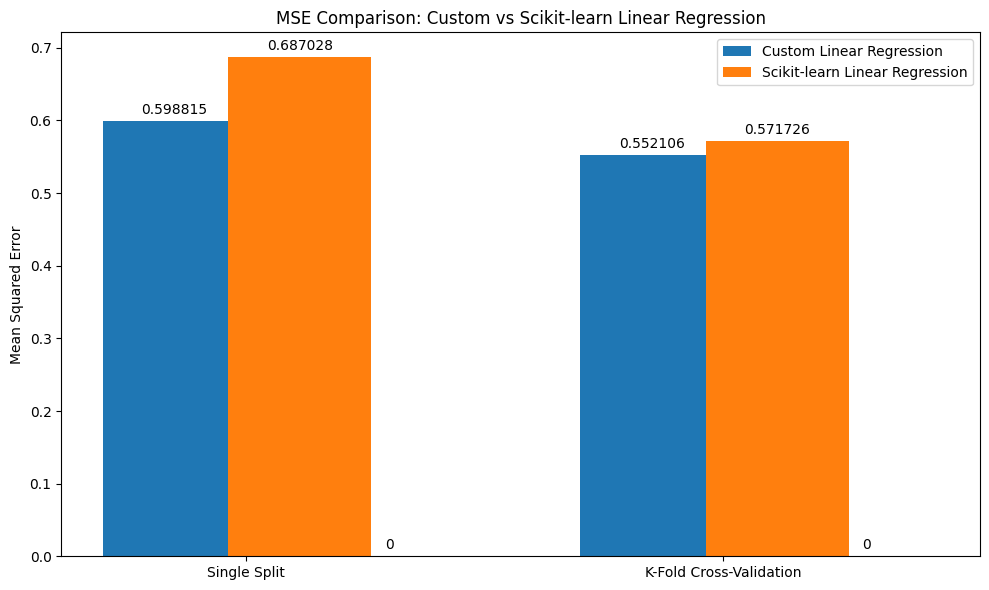

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load dataset
dataset = pd.read_csv('/kaggle/input/dm-dataset-2/model_dataset.csv')

# Separate features and target variable
X = dataset.drop(['id', 'score'], axis=1)
y = dataset['score']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_splits = 5

# K-Fold Cross-Validation


# Calculate average MSE for K-Fold Cross-Validation
custom_linear_mse_folds = []
sklearn_linear_mse_folds = []

# K-Fold Cross-Validation
for train_index, test_index in k_fold_cross_validation(X_scaled, y, k=n_splits):
    # Splitting data
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and evaluate custom linear regression
    lin_reg_custom = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
    lin_reg_custom.fit(X_train, y_train)
    predictions_custom_linear = lin_reg_custom.predict(X_test)
    custom_linear_mse_folds.append(mean_squared_error(y_test, predictions_custom_linear))

    # Train and evaluate scikit-learn linear regression
    lin_reg_sklearn = LinearRegression()
    lin_reg_sklearn.fit(X_train, y_train)
    predictions_sklearn_linear = lin_reg_sklearn.predict(X_test)
    sklearn_linear_mse_folds.append(mean_squared_error(y_test, predictions_sklearn_linear))

# Calculate average MSE for K-Fold Cross-Validation
average_mse_custom_linear = np.mean(custom_linear_mse_folds)
average_mse_sklearn_linear = np.mean(sklearn_linear_mse_folds)

# Store single train-test split MSE for comparison
single_split_mse_custom_linear = mse_custom_linear
single_split_mse_sklearn_linear = mse_sklearn_linear

# Prepare data for visualization
mse_data = {
    'Custom Linear Regression': [single_split_mse_custom_linear, average_mse_custom_linear],
    'Scikit-learn Linear Regression': [single_split_mse_sklearn_linear, average_mse_sklearn_linear]
}








import matplotlib.pyplot as plt

# Data for plotting
labels = ['Single Split', 'K-Fold Cross-Validation']
custom_mse = mse_data['Custom Linear Regression']
sklearn_mse = mse_data['Scikit-learn Linear Regression']

x = np.arange(len(labels))  # the label locations
width = 0.3  # Decreased width of the bars

# Create a larger figure size for the plot
plt.figure(figsize=(10, 6))
ax = plt.subplot()

rects1 = ax.bar(x - width/2, custom_mse, width, label='Custom Linear Regression')
rects2 = ax.bar(x + 0.75*width/2, sklearn_mse, width, label='Scikit-learn Linear Regression')
rects3 = ax.bar(x + 2*width/2, [0], width, label='')
# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Mean Squared Error')
ax.set_title('MSE Comparison: Custom vs Scikit-learn Linear Regression')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding labels on top of the bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
plt.tight_layout()
plt.show()


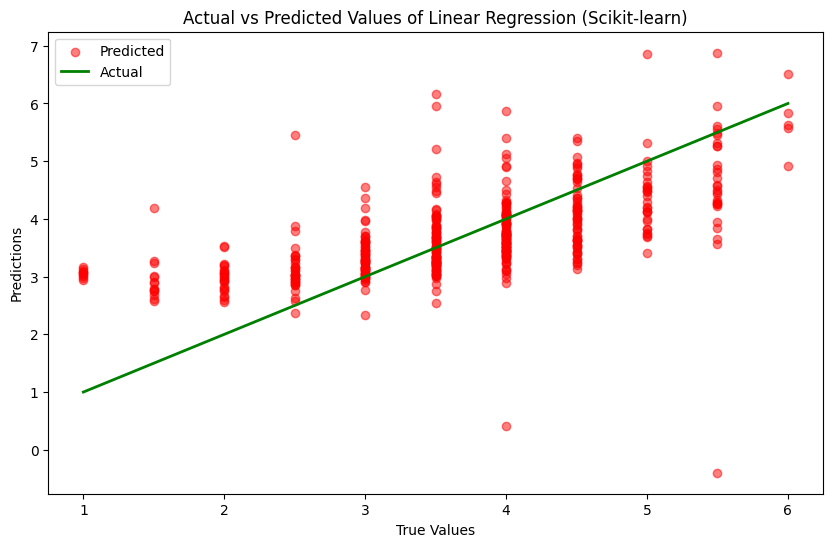

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions_sklearn_linear, color='red', alpha=0.5, label='Predicted')
# Plot a line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'green', linewidth=2, label='Actual')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Actual vs Predicted Values of Linear Regression (Scikit-learn)')
plt.legend()
plt.show()


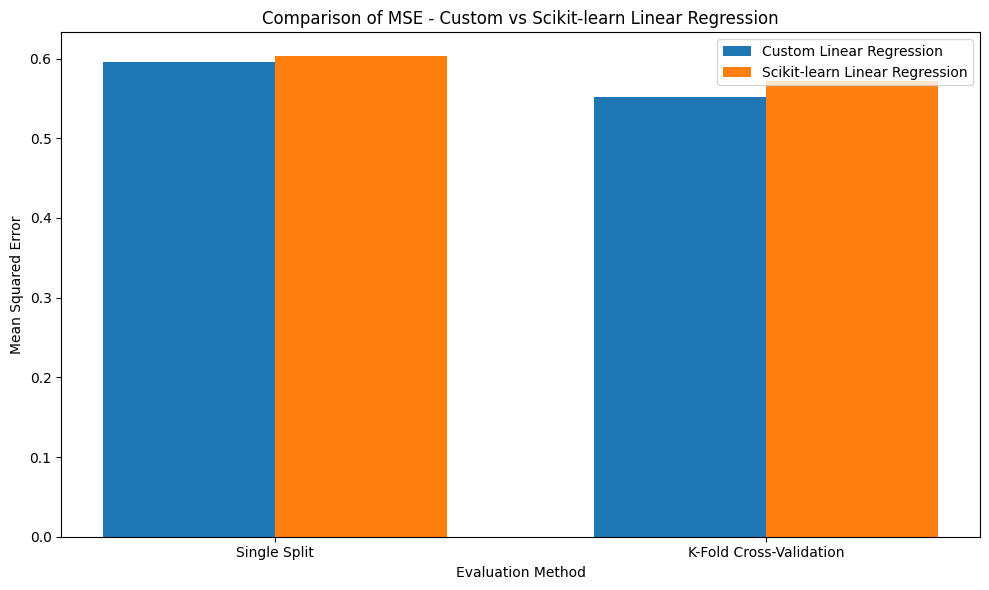

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming custom_mse and sklearn_mse are lists that contain the MSE values for the custom and scikit-learn implementations respectively
# For example:
# custom_mse = [single_split_mse_custom_linear, average_mse_custom_linear]
# sklearn_mse = [single_split_mse_sklearn_linear, average_mse_sklearn_linear]

labels = ['Single Split', 'K-Fold Cross-Validation']
index = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(index, custom_mse, bar_width, label='Custom Linear Regression')
plt.bar(index + bar_width, sklearn_mse, bar_width, label='Scikit-learn Linear Regression')

plt.xlabel('Evaluation Method')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of MSE - Custom vs Scikit-learn Linear Regression')
plt.xticks(index + bar_width / 2, labels)
plt.legend()
plt.tight_layout()
plt.show()
